In [1]:
# Libraries to install in docker: numpy, pandas, matplotlib, cv2, keras, mrcnn, keras_tqdm

# Math manipulation
import numpy as np
import pandas as pd
import math

# Vizualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline 

# Image processing
import cv2

# Utilities
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical

# deep learning
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.models import load_model


from mrcnn.config import Config
from mrcnn.model import MaskRCNN

#utils
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [7]:
def preProcessFrame(_frame):
    _frame = cv2.flip(_frame, 0)
    
    ## Brightness and contrast
    # new_image = (old_image) × (contrast/127 + 1) - contrast + brightness
    # contrast and brightness are integers in the range [-127,127]
    brightness = 20
    contrast = -20
    _frame2 = np.int16(_frame) * (contrast/127+1) - contrast + brightness
    _frame2 = np.clip(_frame2, 0, 255)
    _frame2 = np.uint8(_frame2)

    return _frame2

raw_image_path = 'raw_image.jpg'

# Class Scene recognition

In [3]:
label_names=['Normal situation',
             'Aggression: frontal',
             'Aggression: lateral', 
             'Aggression: vertical',
             'Aggression: overtaking', 
             'Curiosity',
             'Queuing: fewer', 
             'Queuing: crowded',
             'Drinking water', 
             'Low visibility']

model_path = 'assets/scene_recognition_model.h5'
img_height = 256
img_width = 256

# Initialization (Run once)
model = load_model(model_path)
print (model.summary())
#print (model.get_weights())

W1009 12:34:16.574422 140534198892352 deprecation_wrapper.py:119] From /home/ml-station/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1009 12:34:16.653731 140534198892352 deprecation_wrapper.py:119] From /home/ml-station/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1009 12:34:16.713838 140534198892352 deprecation_wrapper.py:119] From /home/ml-station/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1009 12:34:16.891111 140534198892352 deprecation_wrapper.py:119] From /home/ml-station/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       295168    
__________

In [4]:
# Brief: plot a bar graph with the probability of each predicted class
def plot_probability(prediction):
    plt.xticks(range(10))
    plt.xticks(np.linspace(0, 9, num=10), label_names)
    plt.yticks(np.linspace(0, 1, num=6), ('0 %', '20 %', '40 %', '60 %', '80 %', '100 %'))
    thisplot = plt.bar(range(10), prediction, color="blue")
    plt.ylim([0, 1])
    
    ax = plt.gca()
    ax.yaxis.grid(True)
    
    plt.xticks(rotation=45, ha='right')
    plt.title ('Probability distribution of the prediction')

# Return: class (probabilistic one-hot encoding with 10 positions)
def scene_recognition (raw_image_path, verbose=0):
    raw_image = cv2.resize(cv2.imread(raw_image_path, cv2.IMREAD_GRAYSCALE), (img_height,img_width), interpolation=cv2.INTER_CUBIC)
    raw_image = preProcessFrame (raw_image)
    
    predictions = model.predict(raw_image.reshape(1, img_height, img_width, 1))
    
    if verbose: 
        plt.imshow(raw_image)
        print ('Prediction shape: ' + str(predictions.shape))
            
    return predictions

In [21]:
# run in the API
prediction = scene_recognition (raw_image_path, verbose=0)[0]

In [17]:
prediction.shape

(10,)

Probability array:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Probable class:  Normal situation


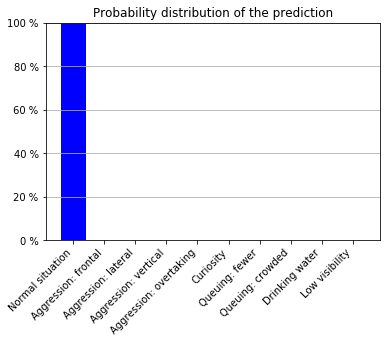

In [22]:
print ('Probability array: ', prediction)
print ('Probable class: ', label_names[np.argmax(prediction)])
plot_probability (prediction)
#plt.savefig('test.jpg')

In [2]:
# #### EVALUATION (JUST FOR DEBUG)
# import os 
# import random
# import gc

# #Image dimensions
# img_height = 256
# img_width = 256
# img_channels = 1
# # TODO: can we work with 4 img_channels (image segmentation)?

# label_names=['Normal situation',
#              'Aggression: frontal',
#              'Aggression: lateral', 
#              'Aggression: vertical',
#              'Aggression: overtaking', 
#              'Curiosity',
#              'Queuing: fewer', 
#              'Queuing: crowded',
#              'Drinking water', 
#              'Low visibility']

# base_dir = '../assets/labeled_photos'


# #A function to read and process the images to an acceptable format for our model
# def read_and_process_image(list_of_images):
#     """
#     Returns two arrays: 
#         X is an array of resized images
#         y is an array of labels
#     """
#     X = [] # images
#     y = [] # labels
    
#     for image in list_of_images:
#         # TODO: try a threshold
#         #img_grey = cv2.resize(cv2.imread(image, cv2.IMREAD_GRAYSCALE), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC)
#         #img_binary = cv2.threshold(img_grey, 128, 255, cv2.THRESH_BINARY)[1]
#         #X.append(img_binary)

#         #X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (img_height,img_width), interpolation=cv2.INTER_CUBIC))  #Read the image
#         X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_GRAYSCALE), (img_height,img_width), interpolation=cv2.INTER_CUBIC))  #Read the image        
        
#         #get the labels
#         if '0_' in image: y.append(0)
#         elif '1_' in image: y.append(1)
#         elif '2_' in image: y.append(2)
#         elif '3_' in image: y.append(3)
#         elif '4_' in image: y.append(4)
#         elif '5_' in image: y.append(5)
#         elif '6_' in image: y.append(6)
#         elif '7_' in image: y.append(7)
#         elif '8_' in image: y.append(8)
#         elif '9_' in image: y.append(9)
#     return X, y

# img_names = [str(base_dir + '/{}').format(i) for i in os.listdir(base_dir)]
# random.shuffle(img_names)

# #get the train and label data
# X, y = read_and_process_image(img_names[:10000])

# #Convert list to numpy array
# X = np.array(X)
# y = np.array(y)

# del img_names
# gc.collect()

# #Lets split the data into train and test set
# # The labels are encodede in one-hot representations
# from sklearn.model_selection import train_test_split

# test_size=0.8
# val_size=0.1

# X_train, X_test, y_train, y_test = train_test_split(
#     X.reshape(X.shape[0], X.shape[1], X.shape[2],1),
#     to_categorical(y, num_classes=10),
#     test_size=test_size)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size))

# #clear memory
# del X
# del y
# gc.collect()

# test_loss, test_acc = model.evaluate(X_test, y_test)
# print('\nTest accuracy:', test_acc)

# # Plot confusion matrix

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# def plot_cm(y_true, y_pred, figsize=(10,10)):
#     cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
#     cm_sum = np.sum(cm, axis=1, keepdims=True)
#     cm_perc = cm / cm_sum.astype(float) * 100
#     annot = np.empty_like(cm).astype(str)
#     nrows, ncols = cm.shape
#     for i in range(nrows):
#         for j in range(ncols):
#             c = cm[i, j]
#             p = cm_perc[i, j]
#             if i == j:
#                 s = cm_sum[i]
#                 annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
#             elif c == 0:
#                 annot[i, j] = ''
#             else:
#                 annot[i, j] = '%.1f%%\n%d' % (p, c)
#     cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
#     cm.index.name = 'Actual'
#     cm.columns.name = 'Predicted'
#     fig, ax = plt.subplots(figsize=figsize)
#     sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, linewidths=.5)
    

# predictions = model.predict(X_test)
# plot_cm(np.array([np.argmax(xi) for xi in y_test]), np.array([np.argmax(xi) for xi in predictions]))
# n=0
# for i in label_names:
#     print('Class ' + str(n) + ': ' + i)
#     n+=1



# Class Instance segmentation

In [3]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Initialization (Run once)
# define the custom configuration (the other variables have good default values)
class config(Config):
    NAME = "barnInstanceSegmentation"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 80
    DETECTION_MIN_CONFIDENCE = 0.4
    DETECTION_NMS_THRESHOLD = 0.1
    DETECTION_MAX_INSTANCES = 150
    #I think that the input size can be modified
weight_path = 'assets/mask_rcnn_coco.h5'
rcnn = MaskRCNN(mode='inference', model_dir='./', config=config()) # define the model
rcnn.load_weights(weight_path, by_name=True) # load coco model weights

W1010 17:35:02.621857 140113320318784 deprecation_wrapper.py:119] From /home/ml-station/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1010 17:35:02.661167 140113320318784 deprecation_wrapper.py:119] From /home/ml-station/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1010 17:35:02.667124 140113320318784 deprecation_wrapper.py:119] From /home/ml-station/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1010 17:35:02.704288 140113320318784 deprecation_wrapper.py:119] From /home/ml-station/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_

In [4]:
# Export workarround
from mrcnn.visualize import *
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, verbose=True, save_img=False, image_path=""):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    _, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if save_img:
        plt.savefig(image_path,bbox_inches='tight', pad_inches=-0.5,orientation= 'landscape')
    if verbose:
        plt.show()
    return ax

In [5]:
# Feature calculation
def isMilking (result):
    x1=1250
    y1=250
    x2=1500
    y2=30
    # If there is a cow in the AMS area, return true
    for cow in result['rois'][result['class_ids']==20]:
        if cow[1]>x1 and cow[1]<x2 and cow[0]>y2 and cow[0]<y1: 
            return True
    return False

# Distance metric, 2D
def euclidianDistance (x1, y1, x2, y2):
    return math.sqrt((y1-y2)*(y1-y2) + (x1-x2)*(x1-x2))
  
# Feature calculation: nearest cow to each cow (return an 1D array with the same lengh as the input)
def minDistanceBoxes(result):
    dist = []
    for cow in result['rois'][result['class_ids']==20]:
        dist.append(np.inf)
        for neighbour in result['rois'][result['class_ids']==20]:
            d = euclidianDistance (cow[1], cow[0], neighbour[1], neighbour[0])
            if (d<dist[-1] and d!=0):
                dist[-1] = d
    #print("-----------------------")
    return dist

# Feature calculation
def countCows (result):
    return result['rois'][result['class_ids']==20].shape[0]

# Feature calculation
def countHumans (result):
    return result['rois'][result['class_ids']==1].shape[0]

def instance_segmentation (raw_image_path, output_image_path="foo.jpg", verbose=0):
    frame = cv2.imread(raw_image_path, cv2.IMREAD_COLOR)
    #frame = load_img(raw_image_path)
    frame = preProcessFrame (frame)
    if verbose: plt.imshow(frame)
        
    img = img_to_array (frame)
    if verbose: print('Shape on input: ', img.shape)
    results = rcnn.detect([img], verbose=verbose)
    
    img = display_instances(img, 
                        results[0]['rois'], 
                        results[0]['masks'], 
                        results[0]['class_ids'],
                        class_names, 
                        results[0]['scores'],
                        title='Frame instance segmentation',
                        verbose=verbose,
                        save_img=False,
                        image_path=output_image_path)
    features = {}
    features['is_milking'] = isMilking(results[0])
    features['distance_array'] = minDistanceBoxes(results[0])
    features['n_cows'] = countCows(results[0])
    features['n_humans'] = countHumans(results[0])

    return img, features

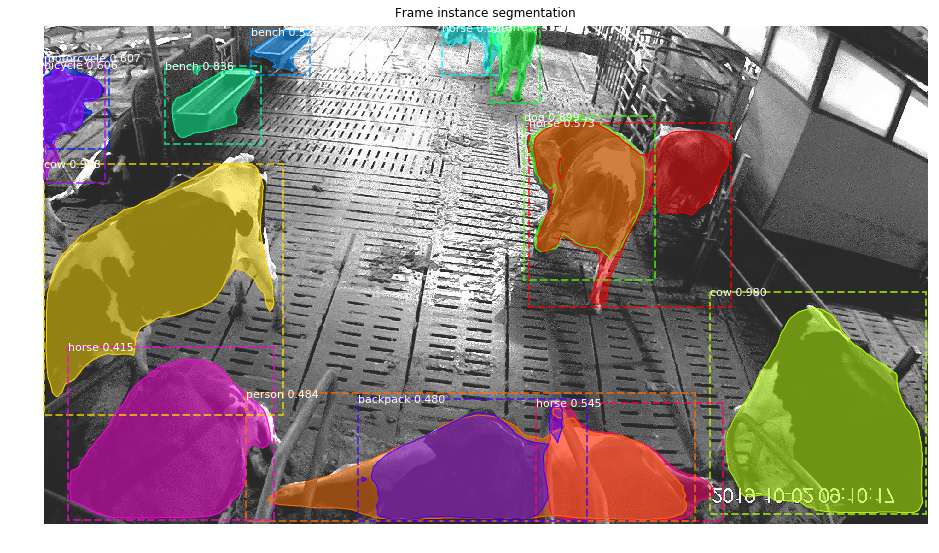

In [8]:
# run in the API
img, features = instance_segmentation (raw_image_path, verbose=0)

In [9]:
output_image_path = 'segmented.jpg'
img.figure.savefig(output_image_path, bbox_inches='tight',orientation= 'landscape')

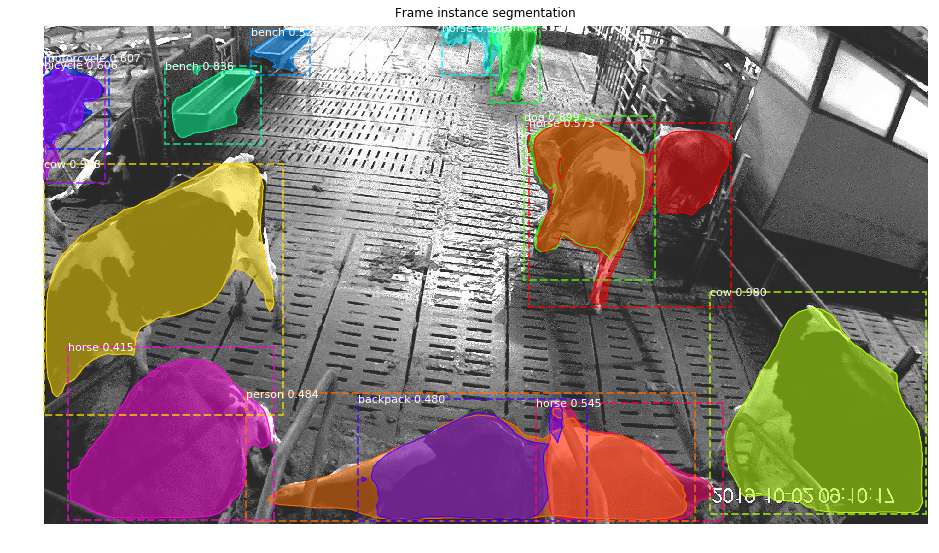

In [10]:
img.figure

In [11]:
features

{'is_milking': False,
 'distance_array': [1472.4808997063426, 1472.4808997063426],
 'n_cows': 2,
 'n_humans': 1}